## Model Optimization

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [5]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
df = pd.read_csv('df_for_visualization_rev_fix.csv')
df

,State,NAICS,ApprovalDate,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,LowDoc,DisbursementDate,DisbursementGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,DaysToDisbursement,Ratio,Recession,RealEstate
0,IN,Retail_trade,1997-02-28,84,4,Yes,0,0,Yes,Undefined,Y,1999-02-28,60000.0,P I F,0.0,60000.0,48000.0,730,0.80,No,No
1,IN,Accom/Food_serv,1997-02-28,60,2,Yes,0,0,Yes,Undefined,Y,1997-05-31,40000.0,P I F,0.0,40000.0,32000.0,92,0.80,No,No
2,IN,Healthcare/Social_assist,1997-02-28,180,7,No,0,0,Yes,Undefined,N,1997-12-31,287000.0,P I F,0.0,287000.0,215250.0,306,0.75,No,No
3,CT,Manufacturing,1997-02-28,120,19,No,0,0,Yes,Undefined,N,1997-06-30,517000.0,P I F,0.0,517000.0,387750.0,122,0.75,No,No
4,FL,Other_no_pub,1997-02-28,84,1,Yes,0,0,Yes,Undefined,Y,1998-06-30,45000.0,P I F,0.0,45000.0,36000.0,487,0.80,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
591745,MD,Manufacturing,1997-02-27,60,20,No,0,0,Yes,Undefined,N,1997-06-30,50000.0,P I F,0.0,50000.0,25000.0,123,0.50,No,No
591746,CA,Manufacturing,1997-02-27,36,40,No,0,0,Yes,Undefined,N,1997-03-31,200000.0,P I F,0.0,200000.0,150000.0,32,0.75,No,No
591747,OH,Retail_trade,1997-02-27,60,6,No,0,0,Yes,Undefined,N,1997-09-30,70000.0,P I F,0.0,70000.0,56000.0,215,0.80,No,No
591748,OH,Retail_trade,1997-02-27,60,6,No,0,0,Yes,Undefined,N,1997-10-31,85000.0,P I F,0.0,85000.0,42500.0,246,0.50,No,No


To match the actual case of a loan officer trying to predict wether a loan will default or not, let's drop a few column such as
- ApprovalDate
- CreateJob
- RetainedJob
- DisbursementDate
- GrAppv
- DaysToDisbursement
- Ratio

MIS_Status will be dropped later, as it's the target column. ChgOffPrinGr is needed to evaluate how much money saved ny the model. Ratio will be changed by the ratio of SBA_Appv and DisbursementGross 

In [7]:
df.drop(['ApprovalDate', 'CreateJob', 'RetainedJob', 'DisbursementDate', 'GrAppv', 'DaysToDisbursement', 'Ratio'],
        axis=1, inplace=True)
df.MIS_Status = df.MIS_Status.apply(lambda x: 0 if x == 'P I F' else 1)
df['Ratio'] = df.SBA_Appv / df.DisbursementGross
df

,State,NAICS,Term,NoEmp,NewExist,FranchiseCode,UrbanRural,LowDoc,DisbursementGross,MIS_Status,ChgOffPrinGr,SBA_Appv,Recession,RealEstate,Ratio
0,IN,Retail_trade,84,4,Yes,Yes,Undefined,Y,60000.0,0,0.0,48000.0,No,No,0.80
1,IN,Accom/Food_serv,60,2,Yes,Yes,Undefined,Y,40000.0,0,0.0,32000.0,No,No,0.80
2,IN,Healthcare/Social_assist,180,7,No,Yes,Undefined,N,287000.0,0,0.0,215250.0,No,No,0.75
3,CT,Manufacturing,120,19,No,Yes,Undefined,N,517000.0,0,0.0,387750.0,No,No,0.75
4,FL,Other_no_pub,84,1,Yes,Yes,Undefined,Y,45000.0,0,0.0,36000.0,No,No,0.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
591745,MD,Manufacturing,60,20,No,Yes,Undefined,N,50000.0,0,0.0,25000.0,No,No,0.50
591746,CA,Manufacturing,36,40,No,Yes,Undefined,N,200000.0,0,0.0,150000.0,No,No,0.75
591747,OH,Retail_trade,60,6,No,Yes,Undefined,N,70000.0,0,0.0,56000.0,No,No,0.80
591748,OH,Retail_trade,60,6,No,Yes,Undefined,N,85000.0,0,0.0,42500.0,No,No,0.50


In [12]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report, roc_curve
from xgboost import XGBClassifier

X = pd.get_dummies(df.drop(['MIS_Status', 'ChgOffPrinGr'], axis=1), drop_first=True)
y = df.MIS_Status

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101, stratify=y)

### Baseline Model

In [17]:
xgb_1 = XGBClassifier(n_jobs=-1, random_state=101)

# cross validate using recall and roc auc on train data
xgb_recallcv_1 = cross_validate(xgb_1, X_train, y_train, scoring=('recall', 'roc_auc'), cv=5, n_jobs=-1)

In [23]:
print('XGB 1 CV Recall Mean :', np.mean(xgb_recallcv_1['test_recall']))
print('XGB 1 CV Recall STD  :', np.std(xgb_recallcv_1['test_recall']))

print('\nXGB 1 CV AUROC Mean  :', np.mean(xgb_recallcv_1['test_roc_auc']))
print('XGB 1 CV AUROC STD   :', np.std(xgb_recallcv_1['test_roc_auc']))

XGB 1 CV Recall Mean : 0.8588307557857291
XGB 1 CV Recall STD  : 0.001408939809659892

XGB 1 CV AUROC Mean  : 0.9763475233600631
XGB 1 CV AUROC STD   : 0.0005232470344626296


              precision    recall  f1-score   support

           0       0.96      0.97      0.96     92282
           1       0.87      0.86      0.87     26068

    accuracy                           0.94    118350
   macro avg       0.92      0.91      0.91    118350
weighted avg       0.94      0.94      0.94    118350



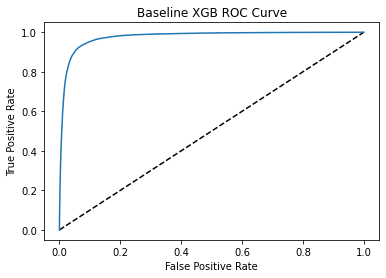

In [24]:
# fit and evaluate on test data
xgb_1.fit(X_train, y_train)

ypred_xgb_1 = xgb_1.predict(X_test)
yprob_xgb_1 = xgb_1.predict_proba(X_test)[:,1]

print(classification_report(y_test, ypred_xgb_1))

# roc auc curve
fpr1, tpr1, threshold1 = roc_curve(y_test, yprob_xgb_1)

plt.plot([0, 1], [0, 1],'k--')
plt.plot(fpr1, tpr1, label='Baseline XGB')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Baseline XGB ROC Curve')
plt.show()

In [39]:
# shift the probability threshold
y_pred = list(map(lambda x: 1 if x == True else 0, (xgb_1.predict_proba(X_test)[:,1] > 0.4)))
print('Threshold 0.4\n', classification_report(y_test, y_pred))

y_pred = list(map(lambda x: 1 if x == True else 0, (xgb_1.predict_proba(X_test)[:,1] > 0.37)))
print('Threshold 0.37\n', classification_report(y_test, y_pred))

Threshold 0.4
               precision    recall  f1-score   support

           0       0.97      0.96      0.96     92282
           1       0.85      0.89      0.87     26068

    accuracy                           0.94    118350
   macro avg       0.91      0.92      0.92    118350
weighted avg       0.94      0.94      0.94    118350

Threshold 0.37
               precision    recall  f1-score   support

           0       0.97      0.95      0.96     92282
           1       0.84      0.90      0.87     26068

    accuracy                           0.94    118350
   macro avg       0.90      0.92      0.91    118350
weighted avg       0.94      0.94      0.94    118350



From three classification report above, we can see there's a trade-off between recall and precission for each target class. The model purpose is to detect which loan possible of default, thus we try to maximize the recall of class 1 of the target feature (default). Maximizing class 1 recall resulting in a the decrease in class 1 precission and class 0 recall. This means we also missed potential profit from a succesful paid in full loan that the model failed to predict. Let's try to calculate how much money does the model saves from each of this threshold (0.5, 0.4, 0.37)

In [56]:
# lets evaluate on all of the data and to calculate how much money does the model saves

y_xgb1_var1 = xgb_1.predict(X)
y_xgb1_var2 = np.array(list(map(lambda x: 1 if x == True else 0, (xgb_1.predict_proba(X)[:,1] > 0.4))))
y_xgb1_var3 = np.array(list(map(lambda x: 1 if x == True else 0, (xgb_1.predict_proba(X)[:,1] > 0.37))))

df_calc = df[['ChgOffPrinGr', 'MIS_Status']]

print('Amount of Money Saved ($) on 0.5 Threshold :', np.sum(df_calc[(df_calc.MIS_Status == 1) &
                                                                     (df_calc.MIS_Status == y_xgb1_var1)].ChgOffPrinGr.values))
print('Amount of Money Saved ($) on 0.4 Threshold :', np.sum(df_calc[(df_calc.MIS_Status == 1) &
                                                                     (df_calc.MIS_Status == y_xgb1_var2)].ChgOffPrinGr.values))
print('Amount of Money Saved ($) on 0.37 Threshold :', np.sum(df_calc[(df_calc.MIS_Status == 1) &
                                                                      (df_calc.MIS_Status == y_xgb1_var3)].ChgOffPrinGr.values))

Amount of Money Saved ($) on 0.5 Threshold : 6549128920.0
Amount of Money Saved ($) on 0.4 Threshold : 7111692296.0
Amount of Money Saved ($) on 0.37 Threshold : 7246416072.0


As expected, from three different treshold, 0.37 gives us the best result. The model prevents more than 7.2 billion dollar lost, almost 7 million dollar differences from 0.5 probability threshold. With this information thus i think baseline model with 0.37 threshold is already a good enough model.

The model selection process will be better if we have interest rate for each loans, so we can calculate how much money we can gain according to the prediction result for each model.

## Saving Model

In [57]:
import pickle

filename = 'xgb_1.sav'
pickle.dump(xgb_1, open(filename, 'wb'))